Дата сет:  13_credit_approve

Задача:
Выполнить исследование и отбор признаков. Обучить алгоритм логистической регрессии для классификации значений. Выполнить подбор гипепараметров. Выбрать лучшую модель. Выполнить прогноз на проверочных данных лучшей моделью.  Снять метрики и ошибки модели. Сделать выводы. Целевая переменная А16-«+/-». 

Данные https://archive.ics.uci.edu/dataset/27/credit+approval

Этот файл касается приложений кредитных карт. Все имена и значения атрибутов были изменены на бессмысленные символы для защиты конфиденциальности данных.

Этот набор данных интересен тем, что в нем есть хорошее сочетание атрибутов — непрерывных, номинальных с небольшим количеством значений и номинальных с большим количеством значений. Также есть несколько пропущенных значений.

В этом блокноте мы создадим автоматический предиктор одобрения кредитных карт с использованием методов машинного обучения, как это делают настоящие банки.

In [231]:
import pandas as pd

In [ ]:
# %pip install ucimlrepo

In [232]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
credit_approval = fetch_ucirepo(id=27) 
  
# data (as pandas dataframes) 
X = credit_approval.data.features 
y = credit_approval.data.targets 
  
# metadata 
print(credit_approval.metadata) 
  
# variable information 
print(credit_approval.variables) 


{'uci_id': 27, 'name': 'Credit Approval', 'repository_url': 'https://archive.ics.uci.edu/dataset/27/credit+approval', 'data_url': 'https://archive.ics.uci.edu/static/public/27/data.csv', 'abstract': 'This data concerns credit card applications; good mix of attributes', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 690, 'num_features': 15, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': [], 'target_col': ['A16'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1987, 'last_updated': 'Wed Aug 23 2023', 'dataset_doi': '10.24432/C5FS30', 'creators': ['J. R. Quinlan'], 'intro_paper': None, 'additional_info': {'summary': 'This file concerns credit card applications.  All attribute names and values have been changed to meaningless symbols to protect confidentiality of the data.\r\n  \r\nThis dataset is interesting because there is a good mix of attributes --

In [233]:
X.head(3)

,A15,A14,A13,A12,A11,A10,A9,A8,A7,A6,A5,A4,A3,A2,A1
0,0,202.0,g,f,1,t,t,1.25,v,w,g,u,0.00,30.83,b
1,560,43.0,g,f,6,t,t,3.04,h,q,g,u,4.46,58.67,a
2,824,280.0,g,f,0,f,t,1.50,h,q,g,u,0.50,24.50,a


In [234]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A15     690 non-null    int64  
 1   A14     677 non-null    float64
 2   A13     690 non-null    object 
 3   A12     690 non-null    object 
 4   A11     690 non-null    int64  
 5   A10     690 non-null    object 
 6   A9      690 non-null    object 
 7   A8      690 non-null    float64
 8   A7      681 non-null    object 
 9   A6      681 non-null    object 
 10  A5      684 non-null    object 
 11  A4      684 non-null    object 
 12  A3      690 non-null    float64
 13  A2      678 non-null    float64
 14  A1      678 non-null    object 
dtypes: float64(4), int64(2), object(9)
memory usage: 81.0+ KB


In [235]:
X.describe()

,A15,A14,A11,A8,A3,A2
count,690.000000,677.000000,690.00000,690.000000,690.000000,678.000000
mean,1017.385507,184.014771,2.40000,2.223406,4.758725,31.568171
std,5210.102598,173.806768,4.86294,3.346513,4.978163,11.957862
min,0.000000,0.000000,0.00000,0.000000,0.000000,13.750000
25%,0.000000,75.000000,0.00000,0.165000,1.000000,22.602500
50%,5.000000,160.000000,0.00000,1.000000,2.750000,28.460000
75%,395.500000,276.000000,3.00000,2.625000,7.207500,38.230000
max,100000.000000,2000.000000,67.00000,28.500000,28.000000,80.250000


In [236]:
y.head(3)

,A16
0,+
1,+
2,+


In [237]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   A16     690 non-null    object
dtypes: object(1)
memory usage: 5.5+ KB


In [238]:
y.describe()

,A16
count,690
unique,2
top,-
freq,383


1. Анализ пропусков
Признаки с пропущенными значениями:

Числовые: A14 (13 пропусков), A2 (12 пропусков)

Категориальные: A1, A4, A5, A6, A7 (6–9 пропусков)

Задача: выбрать стратегию заполнения (среднее/медиана для числовых, мода/«unknown» для категориальных).

2. Кодирование категориальных признаков
Признаки A1, A4–A7, A9–A13 являются объектами (object).
Варианты кодирования:

One-Hot Encoding (если мало уникальных значений)

Label Encoding (если значения упорядочены)

3. Масштабирование данных
Числовые признаки (A15, A14, A11, A8, A3, A2) имеют разные масштабы, что может повлиять на логистическую регрессию. Используем MinMaxScaler или StandardScaler.

4. Проверка выбросов
A15 (макс. 100 000) — возможные выбросы

A14 (макс. 2000) — проверить распределение

A8 (макс. 28.5) — тоже проверить

Сравним несколько стратегий обработки данных:

1. Заполнение пропусков
Числовые признаки (A14, A2):

Вариант 1: Заполнение медианой

Вариант 2: Заполнение средним

Категориальные признаки (A1, A4–A7):

Вариант 1: Заполнение модой (наиболее частым значением)

Вариант 2: Заполнение «unknown»

2. Кодирование категорий
Вариант 1: One-Hot Encoding (разбивает категориальные признаки на несколько бинарных)

Вариант 2: Label Encoding (присваивает числовые значения)

3. Масштабирование
Вариант 1: StandardScaler (нормализация в стандартное нормальное распределение)

Вариант 2: MinMaxScaler (приведение к диапазону [0,1])

После предобработки обучим модели на всех комбинациях и выберем лучший вариант.

In [239]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

Переведем целевую переменную в бинарный формат

In [240]:
y = y['A16'].map({'+': 1, '-': 0})  # Целевая переменная в бинарный формат

Разделим признаки на числовые и категориальные

In [241]:
num_features = X[['A15', 'A14', 'A11', 'A8', 'A3', 'A2']]  # Числовые
cat_features = X[['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A12', 'A13']]  # Категориальные

In [242]:
num_features

,A15,A14,A11,A8,A3,A2
0,0,202.0,1,1.25,0.000,30.83
1,560,43.0,6,3.04,4.460,58.67
2,824,280.0,0,1.50,0.500,24.50
3,3,100.0,5,3.75,1.540,27.83
4,0,120.0,0,1.71,5.625,20.17
...,...,...,...,...,...,...
685,0,260.0,0,1.25,10.085,21.08
686,394,200.0,2,2.00,0.750,22.67
687,1,200.0,1,2.00,13.500,25.25
688,750,280.0,0,0.04,0.205,17.92


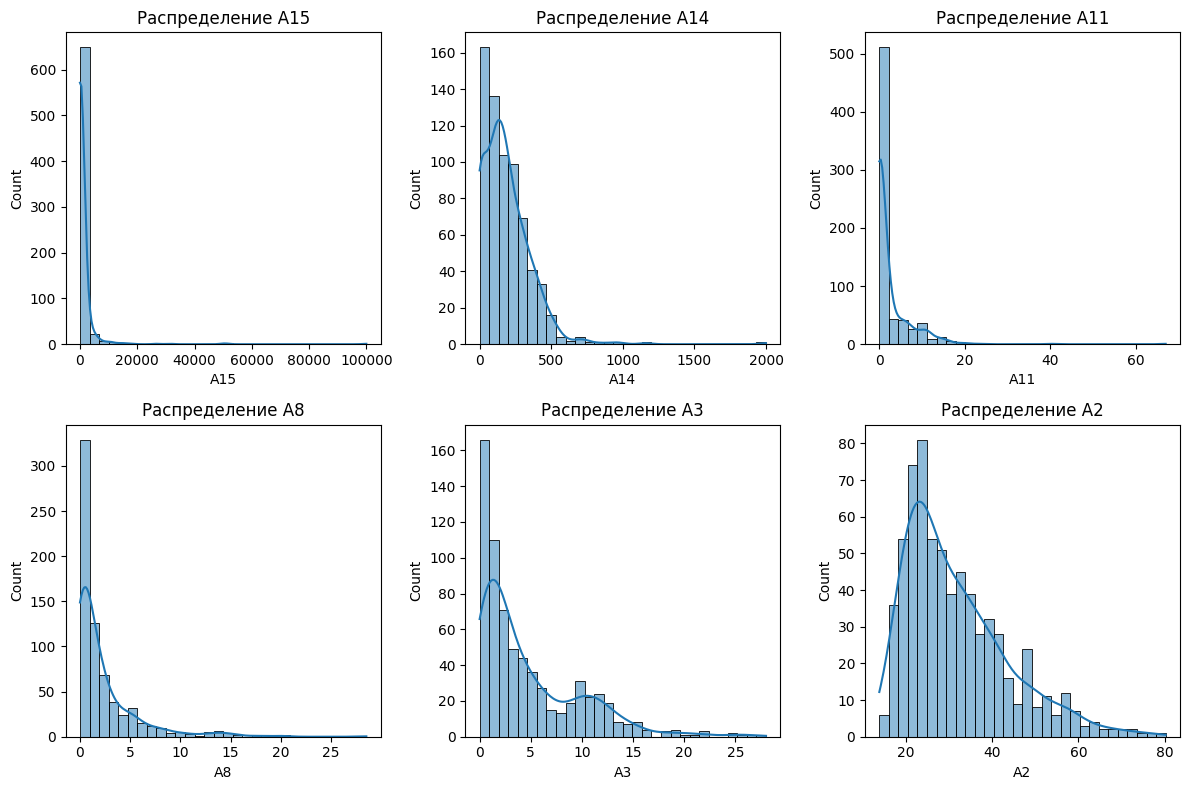

In [243]:
# Визуализация числовых признаков
plt.figure(figsize=(12, 8))
for i, col in enumerate(num_features):
    plt.subplot(2, 3, i + 1)
    sns.histplot(X[col], kde=True, bins=30)
    plt.title(f'Распределение {col}')
plt.tight_layout()
plt.show()

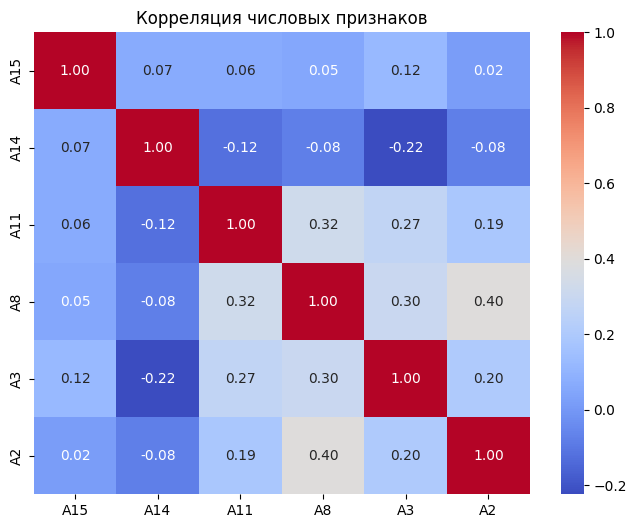

In [244]:
# Отбор только числовых признаков
num_features = X.select_dtypes(include=['number']).columns

# Корреляционная матрица
plt.figure(figsize=(8, 6))
sns.heatmap(X[num_features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляция числовых признаков')
plt.show()

In [245]:
num_features = ['A15', 'A14', 'A11', 'A8', 'A3', 'A2']  # Числовые
cat_features = ['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A12', 'A13']  # Категориальные

In [246]:
# Заполнение пропусков
num_imputers = {
    'median': SimpleImputer(strategy='median'),
    'mean': SimpleImputer(strategy='mean')
}

cat_imputers = {
    'most_frequent': SimpleImputer(strategy='most_frequent'),
    'unknown': SimpleImputer(strategy='constant', fill_value='unknown')
}

In [247]:
# Кодирование категорий
cat_encoders = {
    'one_hot': OneHotEncoder(handle_unknown='ignore'),
    'ordinal': OrdinalEncoder()
}

In [248]:
# Масштабирование
scalers = {
    'standard': StandardScaler(),
    'minmax': MinMaxScaler()
}

In [249]:
# Создаем наборы данных для сравнения 
preprocessed_data = {}

for num_imp_name, num_imputer in num_imputers.items():
    for cat_imp_name, cat_imputer in cat_imputers.items():
        for cat_enc_name, cat_encoder in cat_encoders.items():
            for scaler_name, scaler in scalers.items():
                
                # Обработка числовых данных
                num_pipeline = Pipeline([
                    ('imputer', num_imputer),
                    ('scaler', scaler)
                ])
                
                # Обработка категориальных данных
                cat_pipeline = Pipeline([
                    ('imputer', cat_imputer),
                    ('encoder', cat_encoder)
                ])
                
                # Объединение трансформаций
                preprocessor = ColumnTransformer([
                    ('num', num_pipeline, num_features),
                    ('cat', cat_pipeline, cat_features)
                ])

                # Применение преобразований
                X_transformed = preprocessor.fit_transform(X)

                # Сохранение варианта
                key = f'{num_imp_name}_{cat_imp_name}_{cat_enc_name}_{scaler_name}'
                preprocessed_data[key] = X_transformed

In [250]:
# Вывод количества созданных вариантов предобработанных данных
print(f'Количество вариантов предобработанных данных: {len(preprocessed_data)}')

Количество вариантов предобработанных данных: 16


Отлично! Теперь у нас есть 16 вариантов предобработанных данных. Следующий шаг — обучение логистической регрессии и дерева решений на каждом варианте и сравнение их метрик.

In [251]:
# Выбираем один из вариантов предобработки
X_preprocessed = preprocessed_data['median_most_frequent_one_hot_standard']

In [252]:
# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

In [253]:
# Обучение моделей с подбором гиперпараметров
param_grid_lr = {'C': [0.01, 0.1, 1, 10]}
param_grid_dt = {'max_depth': [3, 5, 10], 'min_samples_split': [2, 5, 10]}

In [254]:
lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5)
lr.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.01, 0.1, 1, 10]})

In [255]:
dt = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=5)
dt.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [3, 5, 10],
                         'min_samples_split': [2, 5, 10]})

In [256]:
# Лучшие модели
best_lr = lr.best_estimator_
best_dt = dt.best_estimator_

In [257]:
print("Лучшая модель логистической регрессии", best_lr)
print("Лучшая модель дерева решений", best_dt)

Лучшая модель логистической регрессии LogisticRegression(C=0.1, max_iter=1000)
Лучшая модель дерева решений DecisionTreeClassifier(max_depth=3, min_samples_split=10)


In [258]:
# Предсказания
y_pred_lr = best_lr.predict(X_test)
y_pred_dt = best_dt.predict(X_test)

In [259]:
# Метрики
metrics = {
    'Accuracy': accuracy_score,
    'Precision': precision_score,
    'Recall': recall_score,
    'F1 Score': f1_score
}

results = {}
for name, metric in metrics.items():
    results[name] = {
        'Logistic Regression': metric(y_test, y_pred_lr),
        'Decision Tree': metric(y_test, y_pred_dt)
    }

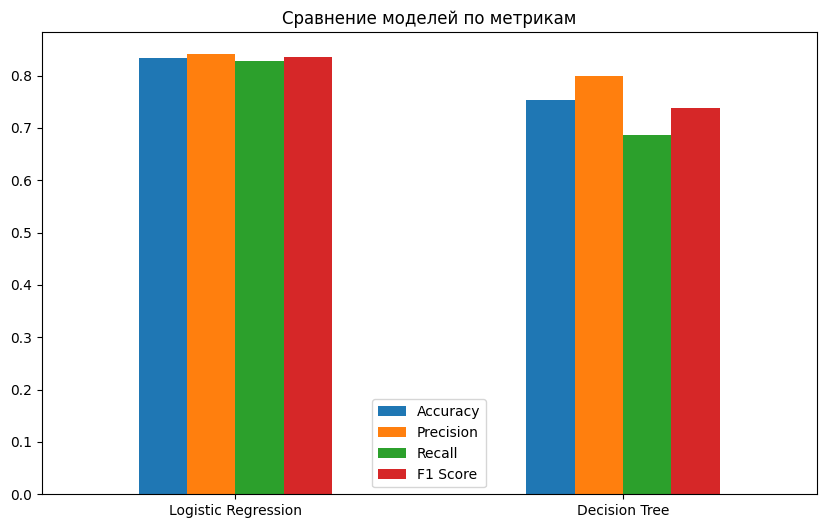

In [260]:
# Визуализация метрик
df_results = pd.DataFrame(results)
df_results.plot(kind='bar', figsize=(10, 6))
plt.title('Сравнение моделей по метрикам')
plt.xticks(rotation=0)
plt.show()

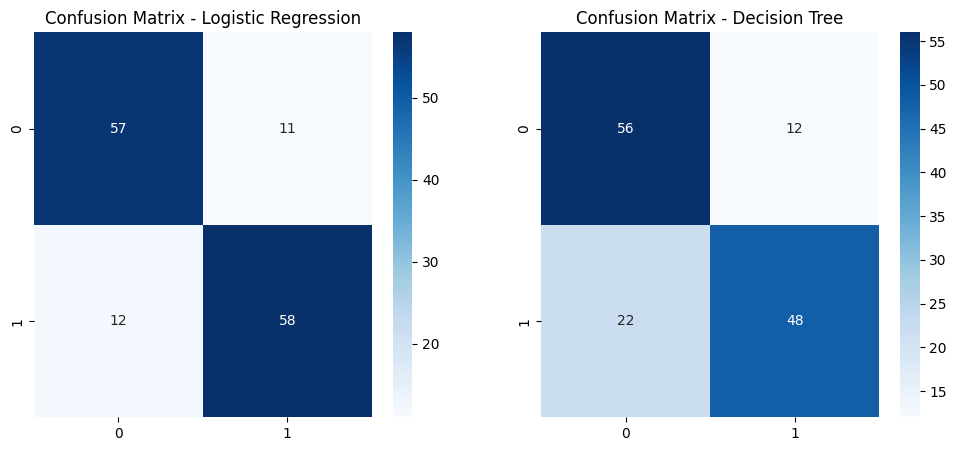

In [261]:
# Матрицы ошибок
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - Logistic Regression')
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix - Decision Tree')
plt.show()

In [262]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

In [263]:
# Функция для оценки модели
def evaluate_model(model, X_test, y_test):
    # Прогноз на тестовых данных
    y_pred = model.predict(X_test)
    
    # Метрики
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    
    # Матрица ошибок
    cm = confusion_matrix(y_test, y_pred)
    
    # Отчет по меткам
    report = classification_report(y_test, y_pred)
    
    # Вывод метрик
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}")
    print("Classification Report:")
    print(report)

In [ ]:
evaluate_model(best_lr, X_test, y_test)

Accuracy: 0.8333
Precision: 0.8406
Recall: 0.8286
F1-score: 0.8345
AUC-ROC: 0.9008
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.83        68
           1       0.84      0.83      0.83        70

    accuracy                           0.83       138
   macro avg       0.83      0.83      0.83       138
weighted avg       0.83      0.83      0.83       138



Результаты для логистической регрессии показывают довольно хорошие показатели:

Accuracy: 83.33% — модель правильно классифицирует примерно 83% случаев.

Precision: 84.06% — из всех прогнозов положительных значений, 84% действительно являются положительными.

Recall: 82.86% — модель правильно классифицирует 83% всех реальных положительных случаев.

F1-score: 83.45% — это среднее гармоническое между precision и recall, указывающее на сбалансированную модель.

AUC-ROC: 0.9008 — высокий показатель, что говорит о хорошем качестве классификации.

Classification Report:
Модель показывает примерно одинаковые результаты для обоих классов, что хорошо, особенно если классы сбалансированы.

Macro average и weighted average также подтверждают хорошие результаты, усредняя показатели для всех классов

In [265]:
evaluate_model(best_dt, X_test, y_test)

Accuracy: 0.7536
Precision: 0.8000
Recall: 0.6857
F1-score: 0.7385
AUC-ROC: 0.8696
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.82      0.77        68
           1       0.80      0.69      0.74        70

    accuracy                           0.75       138
   macro avg       0.76      0.75      0.75       138
weighted avg       0.76      0.75      0.75       138



Оценка модели дерева решений:
Accuracy: 75.36% — модель правильно классифицирует около 75% случаев. Это ниже, чем у логистической регрессии (83.33%).

Precision: 80.00% — из всех прогнозов положительных значений, 80% действительно являются положительными.

Recall: 68.57% — модель правильно классифицирует 69% всех реальных положительных случаев. Это ниже, чем у логистической регрессии (82.86%).

F1-score: 73.85% — среднее гармоническое между precision и recall, что ниже по сравнению с логистической регрессией (83.45%).

AUC-ROC: 0.8696 — это хороший показатель, хотя и немного ниже, чем у логистической регрессии (0.9008).

Classification Report:
Class 0 (отказ в кредите): Модель демонстрирует хорошее качество в точности (precision = 72%) и полноте (recall = 82%).

Class 1 (одобрение кредита): Модель имеет высокую точность (precision = 80%), но низкую полноту (recall = 69%), что говорит о том, что она не находит все положительные примеры.

Macro average и weighted average показывают сбалансированные результаты

In [266]:
print("Лучшие параметры для логистической регрессии:", lr.best_params_)
print("Лучшие параметры для дерева решений:", dt.best_params_)

Лучшие параметры для логистической регрессии: {'C': 0.1}
Лучшие параметры для дерева решений: {'max_depth': 3, 'min_samples_split': 10}


Выводы:
Логистическая регрессия демонстрирует высокие показатели по всем метрикам, особенно по Accuracy, Recall и F1-score, что делает её более сбалансированной и эффективной для этой задачи.

Код для сохранения логистической регрессии и соответствующих шагов:

In [267]:
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [268]:
# Предположим, что у нас уже есть лучший препроцессор и параметры для модели
best_num_imputer = SimpleImputer(strategy='mean')  # пример для числовых данных
best_cat_imputer = SimpleImputer(strategy='most_frequent')  # пример для категориальных данных
best_scaler = StandardScaler()  # пример для масштабирования

In [269]:
# Признаки
num_features = ['A15', 'A14', 'A11', 'A8', 'A3', 'A2']
cat_features = ['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A12', 'A13']

In [270]:
# Создаем pipeline для числовых данных
num_pipeline = Pipeline([
    ('imputer', best_num_imputer),
    ('scaler', best_scaler)
])

In [271]:
# Создаем pipeline для категориальных данных
cat_pipeline = Pipeline([
    ('imputer', best_cat_imputer),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [272]:
# Объединение в ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

In [273]:
# Логистическая регрессия с гиперпараметрами
logreg = LogisticRegression(solver='liblinear')

In [274]:
# Полный pipeline: препроцессинг + модель
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', logreg)
])

In [275]:
# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [276]:
# Тренировка модели
full_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['A15', 'A14', 'A11', 'A8',
                                                   'A3', 'A2']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['A1', 'A4', 'A5', 'A6', 'A7',
                                                   'A9', 'A10', 'A12',
                                                   'A13'])])),
                ('classifier', LogisticRegression(solver='liblinear'))])

In [277]:
# Сохранение всего процесса в файл
joblib.dump(full_pipeline, 'best_logreg_model.pkl')

# Вывод сообщения об успешном сохранении
print("Модель и процесс предобработки успешно сохранены в 'best_logreg_model.pkl'")

Модель и процесс предобработки успешно сохранены в 'best_logreg_model.pkl'
